In [1]:
importCommon()

matplotlib_venn not found, import failed
matplotlib_venn not found, import failed
Seq not found, import failed
Error: bkill not found in PATH, Cluster module cannot be used
Rosetta not in D3
GAP not found, import failed


Error: bkill not found in PATH


pysam not found, import failed
pyBigWig not found, import failed


## 读取与归一化icSHAPE score

In [2]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

class SHAPE:
    def __init__(self, trans_id, rpkm, shape_array):
        self.trans_id = trans_id
        self.rpkm = rpkm
        self.length = len(shape_array)
        self.shape_array = shape_array
    @staticmethod
    def replace(raw_shape_array, raw_item, new_item):
        replaced_shape_array = []
        for item in raw_shape_array:
            if item == raw_item:
                replaced_shape_array.append(new_item)
            else:
                replaced_shape_array.append(item)
        return replaced_shape_array
    @staticmethod
    def divide_median(raw_shape_array):
        import numpy
        normed_shape_array = []
        ## 1. find median
        median = numpy.median([ float(item) for item in raw_shape_array if isfloat(item) ])
        ## 2. each number divide this median
        for shape_score in raw_shape_array:
            if isfloat(shape_score):
                normed_shape_array.append( float(shape_score)/median )
            else:
                normed_shape_array.append( 'NULL' )
        return normed_shape_array
    @staticmethod
    def smooth(raw_shape_array, window_size=50, step=25):
        smoothed_shape_array = []
        start = 0
        while start + window_size < len(raw_shape_array):
            smoothed_reactivity = SHAPE.average_str_array(raw_shape_array[start:start+window_size], min_num=10)
            if smoothed_reactivity:
                smoothed_shape_array.append( smoothed_reactivity )
            else:
                smoothed_shape_array.append( 'NULL' )
            start += step
        # the end
        smoothed_reactivity = SHAPE.average_str_array(raw_shape_array[start:start+window_size], min_num=10)
        if smoothed_reactivity:
            smoothed_shape_array.append( smoothed_reactivity )
        else:
            smoothed_shape_array.append( 'NULL' )
        smoothed_shape_array += ["NULL"] * (len(raw_shape_array) - len(smoothed_shape_array))
        return smoothed_shape_array
    @staticmethod
    def average_str_array(str_array, min_num=10):
        Sum = 0
        Num = 0
        for item in str_array:
            if isfloat(item):
                Sum += float(item)
                Num += 1
        if Num >= min_num:
            return Sum / Num
        else:
            return None
    @staticmethod
    def diff_shape_list(shape_array_1, shape_array_2, ABS=False):
        assert( len(shape_array_1) == len(shape_array_2) )
        
        diff_array = []
        for i in range(len(shape_array_1)):
            if shape_array_1[i] != 'NULL' and shape_array_2[i] != 'NULL':
                if ABS:
                    diff_array.append( abs(float(shape_array_1[i]) - float(shape_array_2[i])) )
                else:
                    diff_array.append( float(shape_array_1[i]) - float(shape_array_2[i]) )
            else:
                diff_array.append( 'NULL' )
        
        return diff_array


class icSHAPE:
    def __init__(self, fileName):
        self.shape_list = {}
        IN = open(fileName)
        line = IN.readline()
        while line:
            if not line.startswith('#'):
                data = line.strip().split()
                self.shape_list[ data[0] ] = SHAPE(data[0], data[2], data[3:])
            line = IN.readline()
        IN.close()
    def keys(self):
        return sorted(self.shape_list.keys())
    def value(self, trans_id):
        return self.shape_list[trans_id]

def barplot_shape_score(ax, raw_shape_array):
    import numpy
    float_shape_array = []
    for item in raw_shape_array:
        if isfloat(item):
            float_shape_array.append(float(item) - 1)
        else:
            float_shape_array.append(0.0)
    float_shape_array = numpy.array(float_shape_array)
    #float_shape_array = float_shape_array - 1
    float_shape_array[0] = 1
    float_shape_array[-1] = 1
    colors = [ "#84262e" if d>0 else "#332591" for d in float_shape_array ]
    ax.bar(range(len(float_shape_array)), float_shape_array, width=1, linewidth=0, color=colors)

def lineplot_shape_score(raw_shape_array, start, end):
    import numpy
    float_shape_array = []
    for item in raw_shape_array:
        if isfloat(item):
            float_shape_array.append(item)
        else:
            float_shape_array.append(0.0)
    float_shape_array = numpy.array(float_shape_array)
    plt.plot( range(start, end), float_shape_array, '-' )


##############################
##### Read SHAPE
##############################

shape_set_vivo = icSHAPE("virus-w50.shape")
shape_set_vitro = icSHAPE("virus-vitro-w50.shape")
keySARS2 = "NC_045512.2"

virus_SARS2_vivo = shape_set_vivo.value(keySARS2).shape_array
virus_SARS2_vitro = shape_set_vitro.value(keySARS2).shape_array

virus_moothed_vivo = SHAPE.smooth(virus_SARS2_vivo, window_size=30, step=1)
virus_divide_vivo = SHAPE.divide_median(virus_moothed_vivo)

virus_moothed_vitro = SHAPE.smooth(virus_SARS2_vitro, window_size=30, step=1)
virus_divide_vitro = SHAPE.divide_median(virus_moothed_vitro)

#virus_replace = SHAPE.replace(virus_divide, 'NULL', 0)

##############################
##### Plot Profile
##############################

#plt.figure(figsize=(20,6))
#plt.subplot(2,1,1)
#barplot_shape_score(virus_divide)
#plt.ylim(-1,1)
#plt.show()

## 画标度尺

In [3]:
def scale_plot(ax, total_len=29903, bold_stick_step=1000, long_stick_step=500, sub_stick_step=100):
    long = 1
    short = 0.8
    ax.plot([1, total_len], [0, 0], linewidth=2.0, c='black')
    for i in range(total_len):
        if i%bold_stick_step == 0:
            ax.plot([i, i], [0, long], linewidth=2.0, c='black')
        elif i%long_stick_step == 0:
            ax.plot([i, i], [0, long], linewidth=1.0, c='black')
        elif i%sub_stick_step == 0:
            ax.plot([i, i], [0, short], linewidth=1.0, c='black')
    #plt.axis('off')

## 画注释

In [4]:
annotations = {
    "5'UTR":    [1,     265,   0, "#d2d280"],
    "ORF1ab":   [266,   21555, 0, "#91b6cd"],
    "CDS1":     [266,   13468, 1, "#89b761"],
    "CDS2":     [13468, 21555, 1, "#b8857c"],
    "CDS3":     [266,   13483, 2, "#81aeb6"],
    "S":        [21563, 25384, 0, "#7a74a8"],
    "ORF3a":    [25393, 26220, 0, "#5b7db7"],
    "E":        [26245, 26472, 0, "#6fa380"],
    "M":        [26523, 27191, 0, "#b5cc80"],
    "ORF6":     [27202, 27387, 0, "#35478c"],
    "ORF7a":    [27394, 27759, 0, "#dad196"],
    "ORF7b":    [27756, 27887, 1, "#dad196"],
    "ORF8":     [27894, 28259, 0, "#8375a9"],
    "N":        [28274, 29533, 0, "#b8857c"],
    "ORF10":    [29558, 29674, 0, "#81aeb6"],
    "3'UTR":    [29675, 29903, 0, "#89b761"]
}

def plot_annotations(ax):
    thickness = 3
    for annot in annotations.values():
        rect = matplotlib.patches.Rectangle((annot[0], 4*annot[2]), annot[1]-annot[0], thickness, fill=True, color=annot[3])
        ax.add_patch(rect)
    ax.set_ylim(0, 12)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


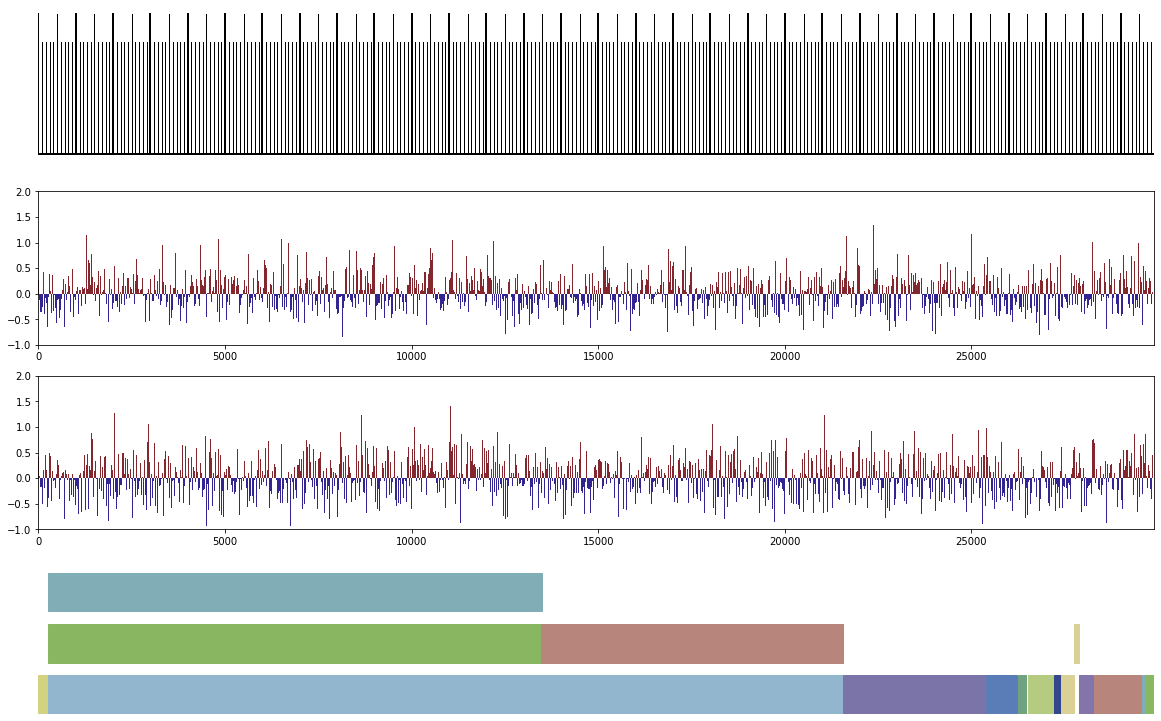

In [5]:
fig, axs = plt.subplots(4,1, figsize=(20,13))
scale_plot(axs[0], total_len=29903, bold_stick_step=1000, long_stick_step=500, sub_stick_step=100)
axs[0].set_axis_off()
barplot_shape_score(axs[1], virus_divide_vivo)
axs[1].set_ylim(-1, 2)
barplot_shape_score(axs[2], virus_divide_vitro)
axs[2].set_ylim(-1, 2)
plot_annotations(axs[3])
axs[3].set_axis_off()

axs[0].set_xlim(0, 29903)
axs[1].set_xlim(0, 29903)
axs[2].set_xlim(0, 29903)
axs[3].set_xlim(0, 29903)
plt.savefig("profiles.pdf")
fig.show()